In [1]:
import sys
sys.path.insert(0, '../../')

# Base packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
from scipy import ndimage as ndi
import matplotlib.colors
import cv2

# Included in anaconda
import glob
import os

# External packages
from moviepy.editor import *
import hyperspy.api as hs
from tqdm import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from temnn.knet import MSDnet, Unet
from temnn.data.mods import local_normalize

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 22})

# Specify GPU for Network Predictions

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# Functions

We will be working with hyperspy objects to make use of their many functionalities.

In [3]:
def to_hs(im_array,im_ref):
    '''
    Function to convert a numpy array (im_array) into a hyperspy object 
    and set scale equal to that of a previously defined hyperspy object (im_ref)
    
    Returns a calibrated hyperspy object im_cal
    '''
    im_cal=hs.signals.Signal2D(im_array)
    
    im_cal.axes_manager.signal_axes[0].scale=im_ref.axes_manager.signal_axes[0].scale
    im_cal.axes_manager.signal_axes[1].scale=im_ref.axes_manager.signal_axes[1].scale

    im_cal.axes_manager.signal_axes[0].units=im_ref.axes_manager.signal_axes[0].units
    im_cal.axes_manager.signal_axes[1].units=im_ref.axes_manager.signal_axes[1].units
    
    return im_cal

We will likely be calculating the dose a few times I've put it into a function, docstring below should explain it

In [4]:
def compute_dose_rate(
    intensity,brightness,
    area,exposure):
    '''
    Function to compute dose given intensity integrated over an area
    Brightness calibration and exposure time required
    
    Return dose in units of electrons per angstrom^2 per second
    '''
    dose_rate=(intensity*brightness_cal)/(area*exposure)/100
    
    return dose_rate

# Load data

In [5]:
folder='../experimental_data/LiuPei/CoSe2-3-export'
files=glob.glob(r'{}/*.dm4'.format(folder))
# We can output the filenames gathered by glob to make sure they are correct
files

['../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000007_0001.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000000_0000.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000007_0000.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000000_0001.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000007_0002.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000000_0002.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000007_0003.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000000_0003.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000007_0004.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000000_0004.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000008_0000.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_000001_0000.dm4',
 '../experimental_data/LiuPei/CoSe2-3-export/CoSe2-3_export_0000

In [6]:
i=hs.load(files,lazy=True,stack=True)

In [7]:
output_dir='{}/processing_output'.format(folder)
# Check if an output folder exists first, if not then creates one (will only create one the first time for a new dataset)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [8]:
# Saving the whole stack as a hyperspy object in this new output folder (you could do this as a tif or hdf5)
# This is smaller than the combination of all the dm4 files
i.save('{}/stack.hspy'.format(output_dir),overwrite=True)

In [9]:
# Now I can load the hyperspy file rather than use the lazy-loaded individual files
i=hs.load('{}/stack.hspy'.format(output_dir),lazy=False)

In [10]:
# This is because we loaded the data as a stack. The stack metadata has each individual frame's metadata
# The original data is in a 'DictionaryTree' but we want to loop through it
# So I am converting it to a standard Python dictionary
stack_metadata=i.original_metadata.stack_elements.as_dictionary()

# An individual frame's metadata is then:
frame_index=1
frame_metadata=stack_metadata['element{}'.format(frame_index)]

In [11]:
i.axes_manager.navigation_axes[0].scale=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']
i.axes_manager.navigation_axes[0].units='s'
i.axes_manager.navigation_axes[0].name='t'
i.axes_manager

<Axes manager, axes: (41|4096, 4096)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               t |     41 |      0 |       0 |     0.2 |      s 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |   4096 |        |      -0 |   0.018 |     nm 
               y |   4096 |        |      -0 |   0.018 |     nm

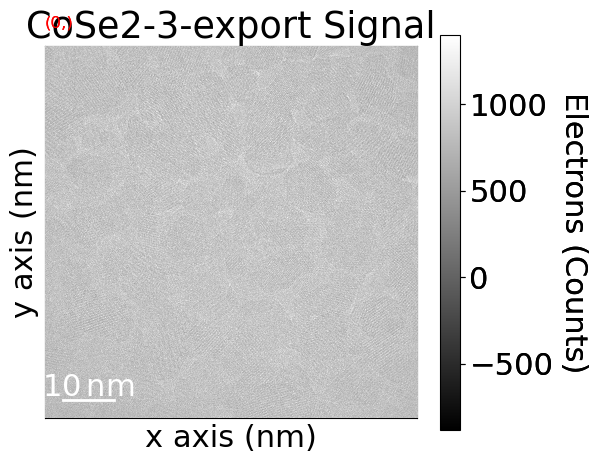

In [12]:
i.plot(navigator='slider')
plt.show()

In [13]:
x_cal,y_cal=i.axes_manager.signal_axes[0].scale,i.axes_manager.signal_axes[1].scale
x_size,y_size=i.axes_manager.signal_axes[0].size,i.axes_manager.signal_axes[1].size

x_nm,y_nm=x_cal*x_size,y_cal*y_size

# Calculate dose rates

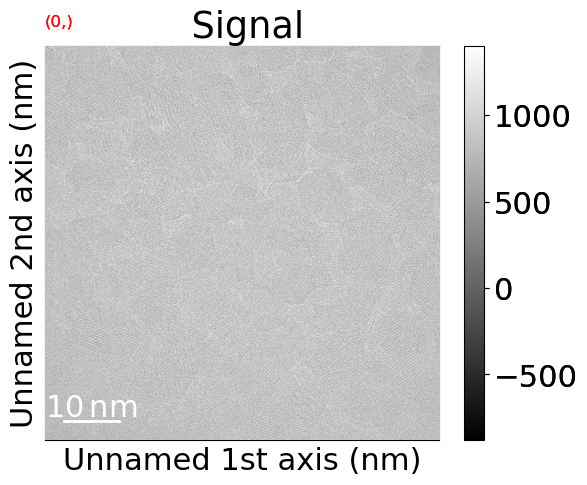

In [14]:
im=to_hs(i.data,i)
im.plot(navigator='slider')

plt.show()

In [15]:
brightness_cal=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
exposure=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']

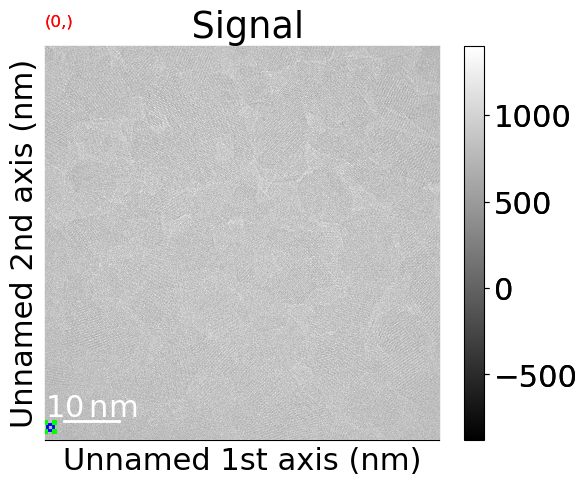

In [16]:
# You can play around with these values and shift it wherever you want, you can even drag it around on the plot
rect=hs.roi.RectangularROI(left=0.5,right=1.5,top=y_nm-3, bottom=y_nm-2) 

im.plot(navigator='slider')
roi=rect.interactive(im, color="blue")
plt.show()

In [17]:
roi_data=roi.data
dose_rate_list=[]
area=roi.inav[0].data.shape[0]*roi.inav[0].data.shape[1]*(x_cal*y_cal)

for n in tqdm(range(0,roi_data.shape[0])):
    dose_rate_list.append(compute_dose_rate(roi_data[n].sum(),brightness_cal,area,exposure))
dose_rates=np.array(dose_rate_list)

100%|██████████| 41/41 [00:00<00:00, 22080.95it/s]


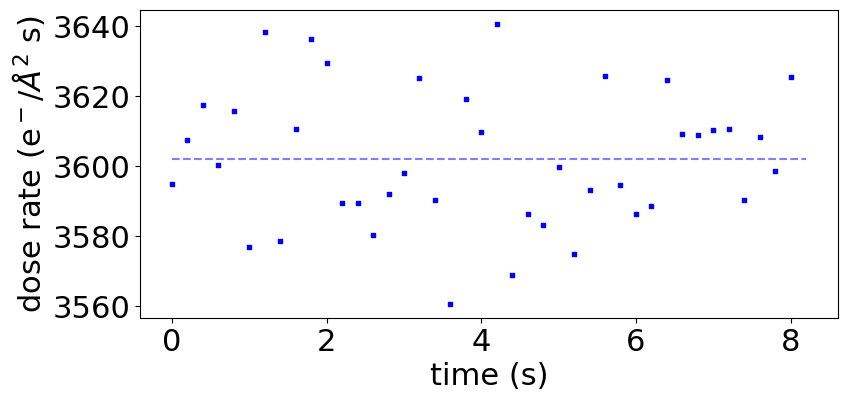

In [18]:
fig,ax=plt.subplots(figsize=(9.0,4.0))
ax.scatter(np.arange(0,len(dose_rates)*exposure,exposure),dose_rates,color='b',marker='s',s=7)
ax.hlines(np.mean(dose_rates[:]),xmin=0*exposure,xmax=len(dose_rates)*exposure,color='b',linestyle='dashed',alpha=0.5)

ax.set_xlabel('time (s)')
ax.set_ylabel('dose rate (e$^-$/$\AA^2$ s)')

plt.show()

In [19]:
doses=dose_rates*exposure

In [20]:
frame_index=10#roi_data.shape[0]-1

frame_dose_rate=dose_rates[frame_index]
frame_dose=doses[frame_index]
frame_cumulative_dose=np.sum(doses[0:frame_index+1])
frame_time=np.round(exposure*frame_index,2)

normalizerange = 12.0/((i.axes_manager.signal_axes[0].scale)*10)
img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
#img.shape = (1,) + img.shape + (1,)

# Scale image distribution

To avoid dead/burning pixels shifting the contrast of the images displayed later I will scale every image remove the upper and lower 1% of the pixel value distribution. Here I visualise the cut.

In [21]:
def trim_imagescale(img, percent=0.1):
    sorted_pixels = sorted(img.flatten())
    n = len(sorted_pixels)
    trim = int(n*percent/100)
    return sorted_pixels[trim: n-trim]

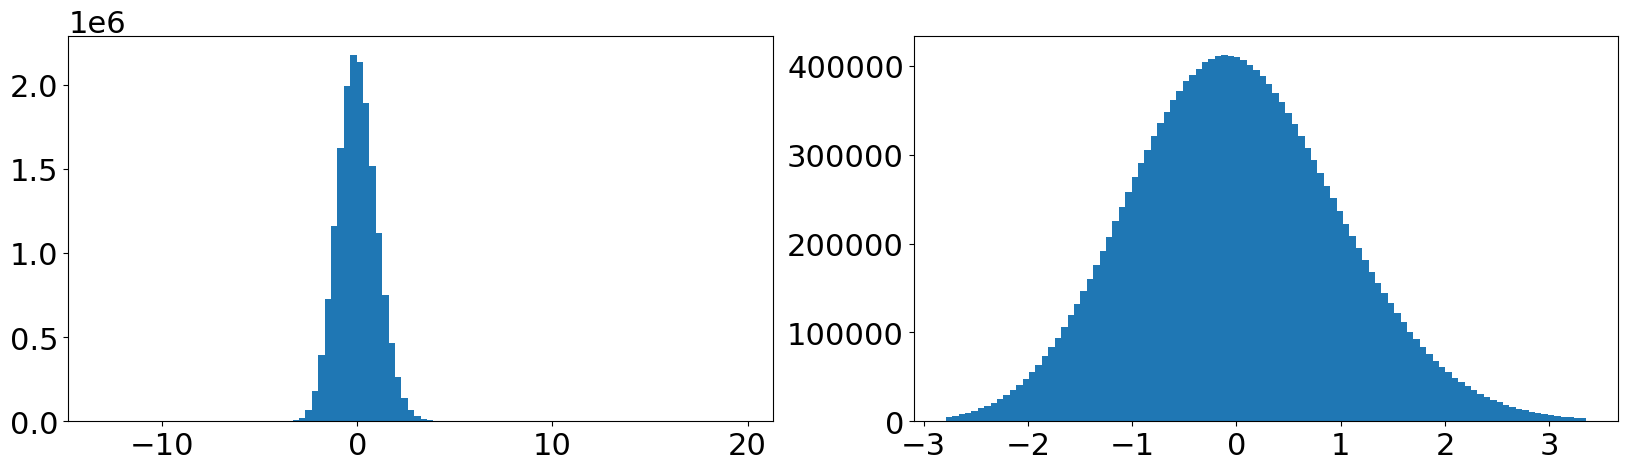

In [22]:
trimmed_pixels = trim_imagescale(img)            # Trim away the upper and lower 1% (default)
scale = min(trimmed_pixels), max(trimmed_pixels) # Save the values to scale

fig,ax=plt.subplots(figsize=(20.0,5.0),nrows=1,ncols=2)
ax[0].hist(img.flatten(),bins=100)
ax[1].hist(trimmed_pixels,bins=100)
plt.show()

# Plot everything

In [44]:
def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    cf = f.shape[0]/2,f.shape[1]/2
    f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.abs(f)**2

Sampling: 0.01778397522866726 x 0.01778397522866726 nm/pixel


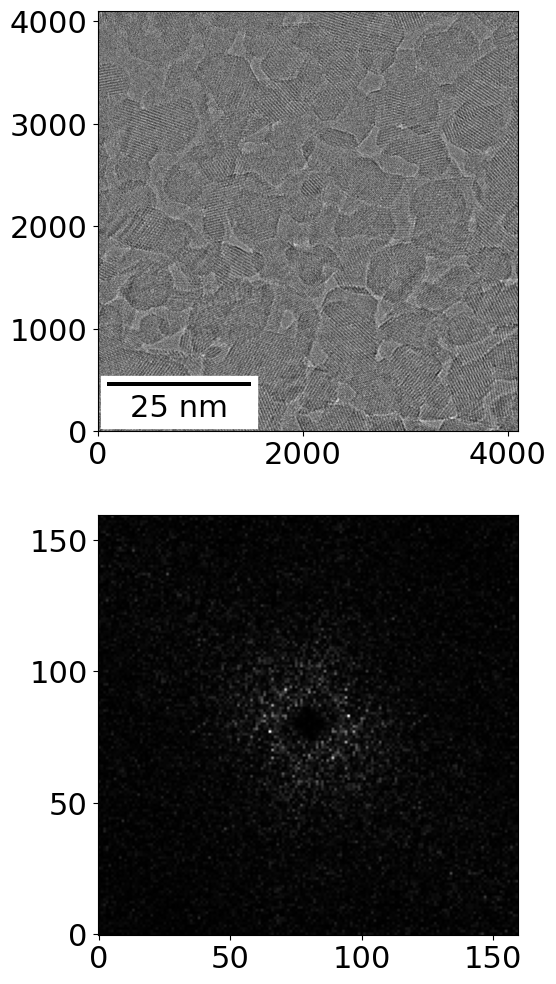

In [47]:
fig,ax=plt.subplots(figsize=(18.0,12.0),nrows=2,ncols=1)
ax[0].imshow(img,origin='lower',cmap='gray',vmin=scale[0],vmax=scale[1])
ax[0].add_artist(ScaleBar(x_cal,units='nm',length_fraction=0.5,color='k',frameon=True,location='lower left'))
ax[1].imshow(fft(img),origin='lower',cmap='gray')
#ax.set_xticks([])
#ax.set_yticks([])

print("Sampling: {} x {} nm/pixel".format(i.axes_manager.signal_axes[0].scale,i.axes_manager.signal_axes[1].scale))

plt.show()